# Heuristic Code

In [3]:
import numpy as np

def char_coeff_FL(X, k):
    if k == 0:
        return 1
    elif k == 1:
        return np.trace(X)
    powers = [X]
    half_k = int(k / 2) 
    for i in range(half_k):
        powers.append(powers[-1] @ X)
    traces = [np.trace(A) for A in powers]
    for i in range(half_k, k):
        traces.append(sum(sum(powers[-1] * powers[i-half_k])))
    x = np.array([[fl_matrix_entry(i, j, traces) for j in range(k)] for i in range(k)])
    return np.linalg.det(x)

def fl_matrix_entry(i, j, l):
    if i > j + 1:
        return 0 
    elif i == j + 1:
        return (len(l) - i - 1)/(i+1)
    else:
        return l[j-i]/(i+1)

def char_coeff_eigen(X, k):
    return esp(np.linalg.eigvalsh(X), k)

def esp(x, k):
    n = len(x)
    if k == 0:
        return 1
    if k == 1:
        return sum(x)
    S = np.zeros((n+1, k))
    for j in range(1, n+1):
        S[j, 0] = S[j-1, 0] + x[j-1]
    for i in range(1, k):
        for j in range(1, n+1):
            S[j, i] = S[j-1, i] + x[j-1] * S[j-1, i-1]
    return S[n, k-1]

def char_poly_built(X, k):
    return np.poly(X)[k]

def char_coeff(X, k):
    #if k < 8:
    #return char_coeff_FL(X, k)
    return char_coeff_eigen(X, k)
    #return char_poly_built(X, k)

def swap(X, i, j):
    if i == j:
        return
    for k in range(len(X)):
        X[k,i], X[k,j]  = X[k,j], X[k,i]
    for k in range(len(X)):
        X[i,k], X[j,k]  = X[j,k], X[i,k]

def conditional_char(X, t, k):
    schur = X[t:, t:] - X[t:, :t] @ np.linalg.inv(X[:t, :t]) @ X[:t, t:]
    return np.linalg.det(X[:t, :t]) * char_coeff(schur, k-t)


def find_subset(A, b, k):
    n = A.shape[1]
    T = []
    npts = 5
    # Use chebyshev nodes
    xs = [np.cos((2*i-1)/(2*npts) * np.pi) for i in range(npts)]
    X0 = np.transpose(A)@A
    V0 = (np.transpose(A) @ np.outer(b, b) @ A)
    Xs = [X0 + x * V0 for x in xs]
    bests = []
    for t in range(k):
        best = -1
        best_heur = 0
        for j in range(t, n):
            chars = []
            for X in Xs:
                swap(X, t, j)
                chars.append(conditional_char(X/1000, t+1, k))
                swap(X, t, j)
            line = np.polyfit(xs, chars, 1)
            heur = line[0]/line[1]
            if heur > best_heur:
                best = j
                best_heur = heur
        for X in Xs:
            swap(X, t, best)
        try:
            while True:
                best = T.index(best)
        except ValueError:
            T.append(best)
        bests.append(best_heur - 1)
    return T, bests

def lin_reg(A, b):
    temp = np.transpose(A) @ b
    return np.dot(b, b) - np.dot(temp, np.linalg.inv(np.transpose(A) @ A) @ temp)

## Orthogonal Matching Pursuit

In [4]:
def omp(A, b, k):
    n = A.shape[1]
    A = A.copy()
    b = b.copy()
    T = []
    bests = []
    for t in range(k):
        best = -1
        best_obj = None
        
        for i in range(n):
            if np.linalg.norm(A[:,i]) < 1e-5:
                continue
            obj = np.dot(b, A[:,i]) / np.linalg.norm(A[:,i])
            if best_obj is None or obj > best_obj:
                best = i
                best_obj = obj 
                
        T.append(best)
        best_vec = A[:, best].copy() / np.linalg.norm(A[:,best])
        for i in range(n):
            A[:,i] -= np.dot(best_vec, A[:,i]) * best_vec
        b -= np.dot(best_vec, b) * best_vec
        bests.append(np.linalg.norm(b)**2)
    return T, bests

# Test Code

In [18]:
import time
def hyp_test(A, b, k_min, k_max):
    hyp_scores = dict()
    hyp_timings = dict()
    for i in range(k_min, k_max):
        start_time = time.time()
        T, bests = find_subset(A,b,i)
        end_time = time.time()
        hyp_timings[i] = end_time - start_time
        hyp_scores[i] = lin_reg(A[:,T], b)        
    return hyp_scores, hyp_timings

def omp_test(A, b, k_min, k_max):
    omp_scores = dict()
    omp_timings = dict()
    for i in range(k_min, k_max):
        start_time = time.time()
        T, bests = omp(A,b,i)
        end_time = time.time()
        omp_timings[i] = end_time - start_time
        omp_scores[i] = lin_reg(A[:,T], b)
    return omp_scores, omp_timings

from sklearn import linear_model
def lasso_test(A, b, threshold, alphas, k_min, k_max):
    # Set the starting scores to be something larger than what we would expect
    lasso_scores = {k : None for k in range(k_min, k_max)}
    lasso_timings = dict()
    for alpha in alphas:
        # Use exponentially decreasing values of alpha to get different sizes of support
        clf = linear_model.Lasso(alpha=alpha, max_iter=10000000)
        start_time = time.time()
        clf.fit(A,b)
        end_time = time.time()
        scores = sorted(list(enumerate(clf.coef_)), key=lambda x: -abs(x[1]))
        ranking = [x[0] for x in scores]
        for k in range(k_min, k_max):
            T = ranking[:k]
            score = lin_reg(A[:,T], b)
            if lasso_scores[k] is None or score < lasso_scores[k]:
                lasso_timings[k] = end_time - start_time
                lasso_scores[k] = score
    return lasso_scores, lasso_timings

import matplotlib.pyplot as plt

def plot_scores(hyp_scores, omp_scores, lasso_scores, k_min, k_max):
    # plot lasso
    if lasso_scores is not None:
        lasso_xs = [k for k in range(k_min, k_max) if lasso_scores[k] is not None]
        lasso_ys = [lasso_scores[k] for k in lasso_xs]
        plt.plot(lasso_xs, lasso_ys, label="Lasso")

    # plot hyp
    if hyp_scores is not None:
        hyp_xs = list(range(k_min, k_max))
        hyp_ys = [hyp_scores[k] for k in hyp_xs]
        plt.plot(hyp_xs, hyp_ys, label="Greedy Cond")

    # plot omp|
    if omp_scores is not None:
        omp_xs = list(range(k_min, k_max))
        omp_ys = [omp_scores[k] for k in omp_xs]
        plt.plot(omp_xs, omp_ys, label="omp")
    
    plt.xticks(list(range(k_min,k_max)))
    plt.xlabel("k")
    plt.ylabel("L2 Error")

    plt.legend()
    plt.show()

# Superconductivity Example

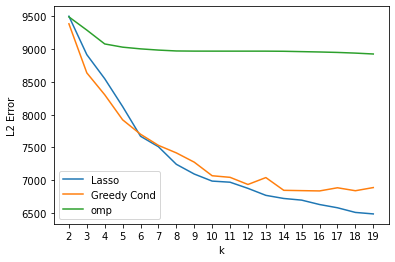

[[2, 6.6976776123046875, 0.18719911575317383, 0.17616868019104004], [3, 7.268214225769043, 0.30234766006469727, 1.1501820087432861], [4, 8.108292818069458, 0.37868189811706543, 0.25760555267333984], [5, 9.325803756713867, 0.4738774299621582, 0.16773056983947754], [6, 10.09481692314148, 0.542060136795044, 0.17697429656982422], [7, 11.307845830917358, 0.694807767868042, 0.21107006072998047], [8, 12.199870347976685, 0.6727960109710693, 0.2021033763885498], [9, 13.409210443496704, 0.7703156471252441, 0.2933309078216553], [10, 14.645751476287842, 0.8720362186431885, 0.25760555267333984], [11, 15.970237016677856, 0.9646439552307129, 0.17697429656982422], [12, 17.40413761138916, 1.1187670230865479, 0.17697429656982422], [13, 18.80592703819275, 1.1102967262268066, 0.17697429656982422], [14, 20.251862287521362, 1.189605712890625, 0.3155937194824219], [15, 21.78556489944458, 1.236715316772461, 0.31125831604003906], [16, 23.432467699050903, 1.3498542308807373, 0.3749582767486572], [17, 33.3386039

In [19]:
import pandas as pd
df = pd.read_csv("/usr/people/kevinshu/Downloads/superconduct.csv", delimiter=",")
df = (df - df.mean())/df.std()
A = df.to_numpy()

b = A[:,-1]
A = A[:,:-1]
k_min = 2
k_max = 20
hyp_scores, hyp_timings = hyp_test(A, b, k_min, k_max)
omp_scores, omp_timings = omp_test(A, b, k_min, k_max)
lasso_scores, lasso_timings = lasso_test(A, b, 9e-02, [1.1 ** (t-65) for t in range(100)], k_min, k_max)
plot_scores(hyp_scores, omp_scores, lasso_scores, k_min, k_max)
print([[k,hyp_timings[k],omp_timings[k],lasso_timings[k] if k in lasso_timings else None] for k in range(k_min, k_max)])

# Violent Crime

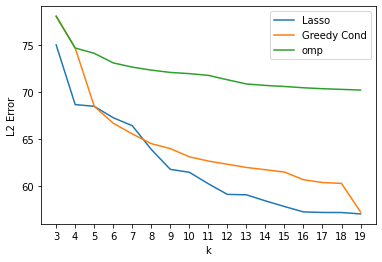

[[3, 4.034012079238892, 0.04151654243469238, 0.058420658111572266], [4, 4.873063325881958, 0.05467820167541504, 0.11518311500549316], [5, 6.50298285484314, 0.06798338890075684, 0.11826157569885254], [6, 7.997608661651611, 0.08088946342468262, 0.05702042579650879], [7, 10.97194766998291, 0.09411334991455078, 0.08289551734924316], [8, 11.638847827911377, 0.1067807674407959, 0.11345100402832031], [9, 13.557286024093628, 0.11992454528808594, 0.14581656455993652], [10, 15.621694087982178, 0.13257884979248047, 0.14824271202087402], [11, 17.907379627227783, 0.14574694633483887, 0.14824271202087402], [12, 19.954864501953125, 0.15844225883483887, 0.13022685050964355], [13, 22.343010425567627, 0.16969537734985352, 0.13022685050964355], [14, 24.464517831802368, 0.17610454559326172, 0.11518311500549316], [15, 27.380080699920654, 0.18267297744750977, 0.15450406074523926], [16, 29.97702980041504, 0.19087529182434082, 0.1651618480682373], [17, 33.22161364555359, 0.19556140899658203, 0.130226850509643

In [21]:
import pandas as pd
df = pd.read_csv("/usr/people/kevinshu/Downloads/CommViolPredUnnormalizedData.txt", delimiter=",")
# Only take interesting columns
df = df.iloc[:,5:-17].replace("?", None).dropna(axis=1)
df = (df - df.mean())/df.std()
A = df.to_numpy()
b = A[:,-1]
A = A[:,:-1]

k_min = 3
k_max = 20
hyp_scores, hyp_timings = hyp_test(A, b, k_min, k_max)
omp_scores, omp_timings = omp_test(A, b, k_min, k_max)
lasso_scores, lasso_timings = lasso_test(A, b, 9e-02, [1.1 ** (t-150) for t in range(300)], k_min, k_max)
plot_scores(hyp_scores, omp_scores, lasso_scores, k_min, k_max)
print([[k,hyp_timings[k],omp_timings[k],lasso_timings[k] if k in lasso_timings else None] for k in range(k_min, k_max)])

In [ ]:
delta_scores, delta_timings = lasso_test(A, b, 9e-02, [1.1 ** (-400)], k_min, k_max)
print(delta_scores)

In [342]:
print(delta_scores)

{3: None, 4: None, 5: None, 6: None, 7: None, 8: None, 9: None, 10: None, 11: 61.83619451649065, 12: None, 13: None, 14: None, 15: None, 16: None, 17: None, 18: None, 19: None}


# Sklearn Diabetes Data

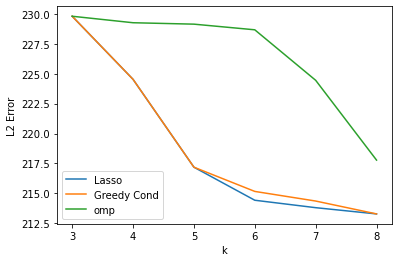

[[3, 0.04265999794006348, 0.0024750232696533203, 0.0014157295227050781], [4, 0.05136728286743164, 0.003184795379638672, 0.0031328201293945312], [5, 0.06238842010498047, 0.003818988800048828, 0.0016391277313232422], [6, 0.07264399528503418, 0.004523754119873047, 0.0031328201293945312], [7, 0.08196353912353516, 0.005166530609130859, 0.0031328201293945312], [8, 0.13997340202331543, 0.0058286190032958984, 0.0031328201293945312]]


In [22]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()
A = diabetes["data"]
for col in range(len(A[0])):
    A[:, col] -= np.mean(A[:,col])
    A[:, col] /= np.std(A[:,col])
b = diabetes["target"]
b -= np.mean(b)
b /= np.std(b)

k_min = 3
k_max = 9
hyp_scores, hyp_timings = hyp_test(A, b, k_min, k_max)
omp_scores, omp_timings = omp_test(A, b, k_min, k_max)
lasso_scores, lasso_timings = lasso_test(A, b, 9e-02, [1.1 ** (t-65) for t in range(100)], k_min, k_max)
plot_scores(hyp_scores, omp_scores, lasso_scores, k_min, k_max)
print([[k,hyp_timings[k],omp_timings[k],lasso_timings[k] if k in lasso_timings else None] for k in range(k_min, k_max)])

# Wine Dataset

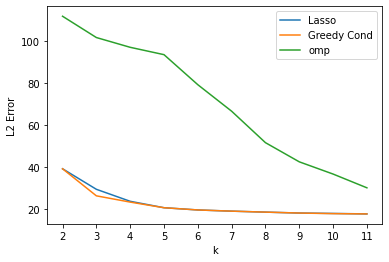

[[2, 0.08982658386230469, 0.0022912025451660156, 0.0047109127044677734], [3, 0.06108713150024414, 0.0029723644256591797, 0.001041412353515625], [4, 0.07883095741271973, 0.003671407699584961, 0.0047109127044677734], [5, 0.1011648178100586, 0.004515886306762695, 0.0047109127044677734], [6, 0.11860537528991699, 0.005314826965332031, 0.0047109127044677734], [7, 0.1562023162841797, 0.006138324737548828, 0.0047109127044677734], [8, 0.19443678855895996, 0.006859540939331055, 0.0011444091796875], [9, 0.41692638397216797, 0.011104583740234375, 0.0011210441589355469], [10, 0.23430418968200684, 0.010859012603759766, 0.001155853271484375], [11, 0.21643733978271484, 0.016420364379882812, 0.0047109127044677734]]


In [23]:
from sklearn.datasets import load_wine
wine = load_wine()
A = wine["data"].astype(float)
b = wine["target"].astype(float)
for col in range(len(A[0])):
    A[:, col] -= np.mean(A[:,col])
    A[:, col] /= np.std(A[:,col])
b -= np.mean(b)
b /= np.std(b)

k_min = 2
k_max = 12
hyp_scores, hyp_timings = hyp_test(A, b, k_min, k_max)
omp_scores, omp_timings = omp_test(A, b, k_min, k_max)
lasso_scores, lasso_timings = lasso_test(A, b, 9e-02, [1.05 ** (t-400) for t in range(500)], k_min, k_max)
plot_scores(hyp_scores, omp_scores, lasso_scores, k_min, k_max)
print([[k,hyp_timings[k],omp_timings[k],lasso_timings[k] if k in lasso_timings else None] for k in range(k_min, k_max)])

# Regression with random matrices

In [8]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.02)
import random
def test(n,m,k):
    T = random.sample(list(range(n)), k)
    T.sort()
    print("T: ", T)
    A = np.random.normal(loc = 0, scale = 1, size = (m,n))
    b = sum(A[:,i] for i in T)
    S1, scores1 = find_subset(A, b, k)
    print("characteristic: ", S1)
    S1.sort()
    s1 = all(s == t for t, s in zip(T, S1))
    lasso = clf.fit(A, b).coef_
    S2 = [a[1] for a in sorted([(-abs(x),i) for i,x in enumerate(lasso)])[:k]]
    S2.sort()
    s2 = all(s == t for t, s in zip(T, S2))
    S3, scores3 = omp(A,b,k)
    print("omp: ", S3)
    S3.sort()
    s3 = all(s == t for t, s in zip(T, S3))
    norm_b = np.linalg.norm(b)
    print([(norm_b**2 - x1, x3) for x1, x3 in zip(scores1, scores3)])
    return (s1,s2,s3)

In [9]:
n = 100
m = 30
iters = 10
count_dict = []
for k in range(6,25):
    counts = [0,0,0]
    for i in range(iters):
        for i, result in enumerate(test(n,m,k)):
            if result:
                counts[i] += 1
    print(counts)
    count_dict.append(counts)
print(count_dict)

T:  [27, 34, 36, 43, 56, 98]
characteristic:  [36, 34, 27, 56, 9, 35]
omp:  [36, 34, 27, 56, 9, 35]
[(132.46165359644783, 170.78247855407432), (87.24761500129657, 104.33627697565508), (53.30017007816417, 60.659663251765046), (36.855474466994195, 39.48010050398141), (25.4091277695793, 25.586777043254802), (17.689584294130213, 16.689584293785607)]
T:  [6, 14, 19, 66, 72, 84]
characteristic:  [19, 84, 72, 14, 6, 66]
omp:  [19, 84, 72, 14, 6, 66]
[(127.36954355563549, 164.92813744061894), (93.14826403419804, 111.0325140607149), (65.23987322492226, 74.20144418756637), (40.43791183947917, 43.49974608908199), (20.968842664671257, 21.029514679092333), (1.0000000002490879, 4.553861353503619e-30)]
T:  [4, 20, 29, 32, 36, 47]
characteristic:  [4, 32, 36, 47, 29, 20]
omp:  [4, 32, 37, 36, 47, 29]
[(58.43350223838078, 71.8438517173549), (47.25608603358313, 56.720495945218104), (37.968183787496116, 43.41403155002055), (27.124911366406153, 34.31808680764085), (18.82715897350232, 22.6110511021922), (0

characteristic:  [75, 99, 73, 95, 63, 81, 7, 8]
omp:  [75, 97, 63, 95, 73, 8, 49, 28]
[(72.61619266432399, 95.8565390825988), (57.693982268349714, 74.66881830096082), (41.666774918775644, 61.653106216109784), (34.65394632127206, 43.518713302236364), (24.740610342540634, 30.84371692378834), (18.777306972284492, 26.018196793501467), (12.599413465725092, 22.04728579150451), (10.076549504513736, 18.042451627200037)]
T:  [5, 9, 31, 32, 38, 43, 50, 75]
characteristic:  [43, 75, 5, 26, 67, 61, 22, 52]
omp:  [43, 75, 5, 31, 57, 32, 84, 9]
[(106.17381547395219, 142.89085854101276), (86.02077528299567, 112.01096133174262), (49.77305677026092, 58.55252166914008), (38.92158593115599, 46.20764707803292), (31.003546744691334, 33.976863708227874), (23.295340148307872, 24.17178720591137), (19.540857878290183, 18.546293649623717), (14.695676911332896, 14.672648979539971)]
T:  [0, 3, 11, 17, 19, 31, 71, 84]
characteristic:  [17, 0, 52, 96, 58, 12, 75, 71]
omp:  [17, 0, 52, 3, 32, 71, 31, 89]
[(96.902010

/usr/lib/python3/dist-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.018660206081195063, tolerance: 0.017991064708052572
  model = cd_fast.enet_coordinate_descent(


characteristic:  [55, 79, 69, 47, 39, 60, 88, 14]
omp:  [55, 79, 69, 47, 39, 60, 68, 72]
[(127.60218498612986, 180.84196311560837), (93.18519015190861, 128.20918790740018), (61.3363177116762, 77.21718866740216), (45.030495268939774, 53.641376968739195), (31.209859783920592, 34.99603017825701), (23.4490386289325, 24.43183767826282), (19.149179423450107, 20.152412300739687), (16.01547760587323, 15.313818342393546)]
T:  [9, 31, 35, 47, 50, 55, 64, 90]
characteristic:  [79, 46, 3, 18, 31, 9, 83, 4]
omp:  [31, 55, 35, 90, 50, 9, 64, 47]
[(134.36615558293704, 186.91717989258856), (109.23249751006168, 149.52404081546706), (91.59137683834365, 104.85374201115346), (72.22577146152065, 77.06902317608008), (58.36969608850046, 52.562471497393126), (46.68359643746149, 33.27695223008448), (36.15248312589662, 13.623255367477405), (29.754113459726597, 1.2684138502547878e-29)]
T:  [19, 21, 22, 61, 70, 73, 81, 91]
characteristic:  [21, 19, 18, 61, 24, 91, 22, 73]
omp:  [21, 19, 18, 61, 24, 91, 22, 73]
[(

characteristic:  [98, 44, 46, 45, 81, 38, 52, 96, 61, 72]
omp:  [42, 46, 18, 31, 47, 64, 1, 34, 10, 36]
[(127.71405430359502, 209.5944324004951), (106.0410412769522, 146.8682303461697), (91.10599896869539, 112.67812613229172), (71.36160573535159, 82.01493439113922), (55.20954618533625, 57.487334364143855), (42.14659110983854, 38.57735645142024), (30.164729889026574, 31.120879015861846), (24.633311469900377, 22.59728044007596), (20.5639339461288, 12.727220206714474), (17.82218655277697, 1.5743430070958395e-29)]
T:  [35, 38, 42, 44, 46, 49, 57, 59, 91, 98]
characteristic:  [57, 46, 34, 44, 17, 53, 47, 65, 41, 96]
omp:  [57, 46, 34, 44, 59, 98, 92, 91, 38, 85]
[(158.38558815548362, 238.43760506548224), (127.5649819245109, 180.2458563437816), (86.75056500185082, 113.98099041992451), (69.87511037248322, 88.77934070217047), (61.905268167509405, 74.84378377493529), (47.90277318317118, 61.44875019248658), (35.38125830894626, 47.790048984474474), (27.3011242917961, 37.34180387110666), (22.39135

KeyboardInterrupt: 